In [1]:
# importing of pycocotools necessary for loading COCO images
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 2.2 MB/s eta 0:00:00a 0:00:01m


In [57]:
# setup chunk
import numpy as np
import pandas as pd
import os
from pycocotools.coco import COCO
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageDraw, ImageOps
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import random

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Data Import
First we import the images of the COCO and the Oxford Street Dataset by creating two respective dataset classes and defining all relevant paths in which the images as well as the annotations are stored.

In [3]:
# paths to annotation files
coco_inst_ann_file = "/kaggle/input/deeplearningproject/data_model/data_model/instances_val2017.json"
coco_caps_ann_file = "/kaggle/input/deeplearningproject/data_model/data_model/captions_val2017.json"

# path to all images
img_dir_all = "/kaggle/input/deeplearningproject/raw_images/raw_images/coco"

# initialize COCO objects
coco = COCO(coco_inst_ann_file)
coco_caps = COCO(coco_caps_ann_file)

loading annotations into memory...
Done (t=0.94s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


In the COCO dataset class we filter in the caption annotations for several keywords to ensure that we only get images from humans. The class returns the actual image as well as all coordinates for bounding boxes of people on the image.

In [4]:
class CocoDataset(Dataset):
    def __init__(self, img_dir, coco, coco_caps, img_ids):
        self.img_dir = img_dir
        self.coco = coco
        self.coco_caps = coco_caps
        self.img_ids = self.filter_img_ids_with_people(img_ids)
        self.person_cat_id = self.coco.getCatIds(catNms=['person'])[0] # get the category id for persons

    def filter_img_ids_with_people(self, img_ids):
        filtered_img_ids = [] # list in which the ids of relevant images are stored
        for img_id in img_ids: # loop through all image ids
            caption_ids = self.coco_caps.getAnnIds(imgIds=img_id)
            captions = self.coco_caps.loadAnns(caption_ids)
            for caption in captions: # filter for captions, append relevant images to the list and stop the loop
                if any(word in caption['caption'].lower() for word in ['person', 'people', 'man', 'woman', 'child']):
                    filtered_img_ids.append(img_id)
                    break
        return filtered_img_ids

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name']) # get the image path based on the directory and the file name
        image = Image.open(img_path).convert("RGB") # open the image

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=[self.person_cat_id])
        anns = self.coco.loadAnns(ann_ids) 
        boxes = [ann['bbox'] for ann in anns] # list storing the bounding box coordinates

        return image, boxes

We extract all image IDs of the images that were downloaded here for visualization purposes. With these images we create the COCO dataset class.

In [6]:
downloaded_imgs = set(os.listdir(img_dir_all))

img_ids = []
for img_info in coco.dataset['images']:
    if img_info['file_name'] in downloaded_imgs:
        img_ids.append(img_info['id'])

coco_dataset = CocoDataset(
    img_dir=img_dir_all,
    coco=coco,
    coco_caps=coco_caps,
    img_ids=img_ids
    )

print(f"Number of Images: {len(coco_dataset)}")

Number of Images: 485


Next, the Oxford dataset is created. Similarly, it returns the image as well as coordinates for the bounding boxes.

In [43]:
class oxfordDataset(Dataset):
    def __init__(self, data_dir, annotations, exclude_frame=None, transform=None):
        self.data_dir = data_dir
        self.data = annotations
        self.exclude_frame = exclude_frame

        self.frames = self.data.groupby('frameNumber')

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame_num = list(self.frames.groups.keys())[idx] # get the frame number
        frame_data = self.frames.get_group(frame_num) # select the entire group of one frame number
        
        img_filename = f"{frame_num}.jpg"
        
        # we exclude one frame since it is damaged
        if self.exclude_frame is not None and frame_num == self.exclude_frame:
            return self.__getitem__((idx + 1) % len(self.frames))
        
        # get the path and open the image if the file can be found
        img_path = os.path.join(self.data_dir, img_filename)
        try:
            image = Image.open(img_path).convert("RGB")
        except (FileNotFoundError, OSError):
            return self.__getitem__((idx + 1) % len(self.frames))  

        body_bboxes = [] # empty list in which bounding box coordinates get stored
    
        # loop through the annotations data and extract bounding box coordinates
        for _, row in frame_data.iterrows():
            body_bbox = [row['bodyLeft'], row['bodyTop'], row['bodyRight'], row['bodyBottom']]
            body_bboxes.append(body_bbox)
        
        # convert coordinates to a tensor object
        body_bboxes = torch.tensor(body_bboxes, dtype=torch.float32) 

        return image, body_bboxes

After having defined the dataset class we set the paths and create the Oxford dataset.

In [44]:
oxford_annotations = pd.read_csv("/kaggle/input/deeplearningproject/data_model/data_model/TownCentre-groundtruth.top", names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])

ox_img = "/kaggle/input/deeplearningproject/raw_images/raw_images/oxford"

oxford_dataset = oxfordDataset(
    data_dir=ox_img,
    annotations=oxford_annotations,
    exclude_frame=1134
)

### Visualize Example Images
For visualization purposes we show 4 example images from both datasets. We also draw all bounding boxes for the respective image to illustrate how the annotations have been done.

In [124]:
def draw_bboxes(image, boxes, color="green"):
    draw = ImageDraw.Draw(image)
    # loop through the bounding boxes and draw them into the image
    for bbox in boxes:
        x, y, width, height = bbox
        draw.rectangle([x, y, x + width, y + height], outline=color, width=4)
    return image

def visualize_images(oxford_dataset, coco_dataset, num_images): 
    # create environment with two rows and four columns
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    # get random indices for both datasets
    oxford_indices = random.sample(range(len(oxford_dataset)), num_images)
    coco_indices = random.sample(range(len(coco_dataset)), num_images)
    
    # loop through the indices, create the images and set them to the correct place in the plot
    for i, index in enumerate(oxford_indices):
        oxford_image, oxford_boxes = oxford_dataset[index]
        
        oxford_boxes = [[body[0], body[1], body[2] - body[0], body[3] - body[1]] for body in oxford_boxes]
        oxford_image_with_boxes = draw_bboxes(oxford_image.copy(), oxford_boxes, color="green")

        axes[0, i].imshow(oxford_image_with_boxes)
        axes[0, i].axis('off')  
    
    # loop through the indices, create the images and set them to the correct place in the plot
    for i, index in enumerate(coco_indices):
        coco_image, coco_boxes = coco_dataset[index]
        coco_image_with_boxes = draw_bboxes(coco_image.copy(), coco_boxes, color="green")

        axes[1, i].imshow(coco_image_with_boxes)
        axes[1, i].axis('off')  
    
    # set headers for each dataset
    fig.text(0.5, 0.9, 'Oxford Dataset', ha='center', va='center', fontsize=20, color='black')
    fig.text(0.5, 0.5, 'COCO Dataset', ha='center', va='center', fontsize=20, color='black')

    plt.tight_layout()
    plt.show()

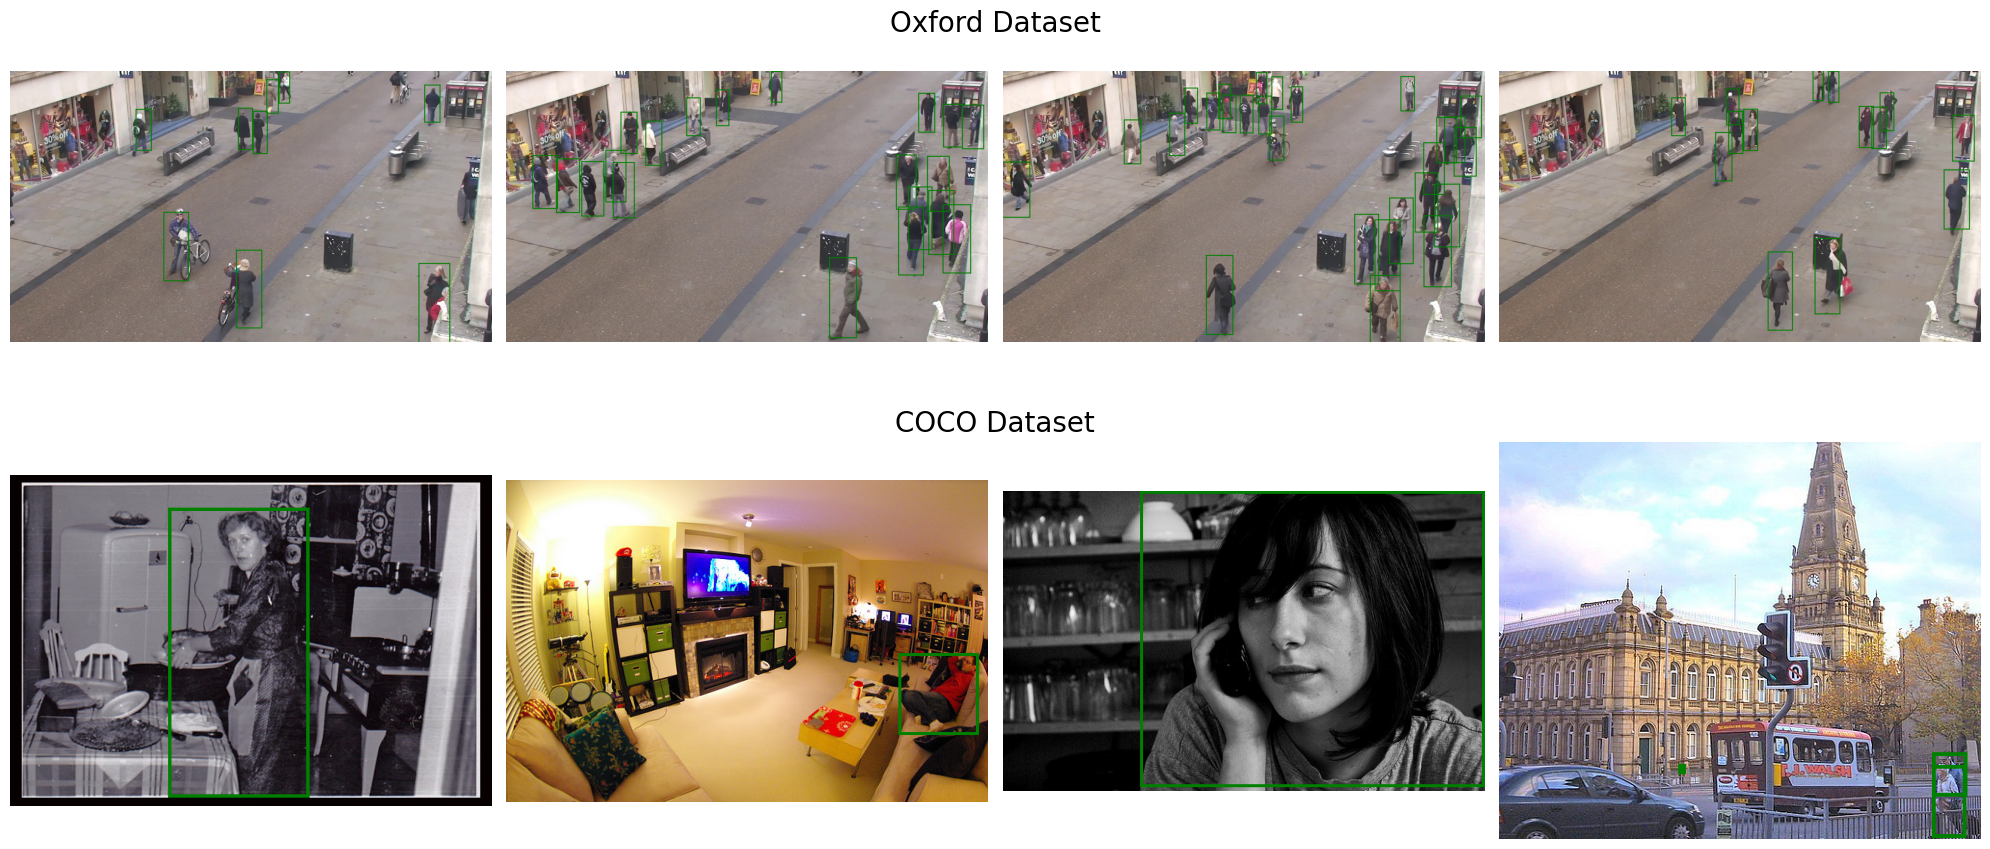

In [127]:
visualize_images(oxford_dataset, coco_dataset, 4)

### Heatmap
Next, we create a heatmap for the Oxford Street Dataset showing which regions of the street are highly frequented. We do so by defining a custom grid. In each of the grid cells we count the number of annotations we get in the dataset. Based on these counts we create a heatmap with the "coolwarm" color mapping and overlay this heatmap on one example image of the dataset to better see the actual regions.

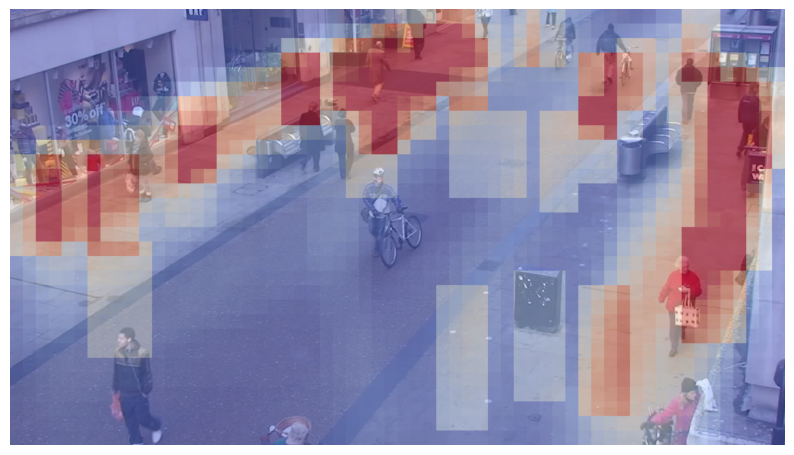

In [164]:
def create_heatmap_grid(grid_size):
    # return a grid for customized grid size
    return np.zeros((grid_size[1], grid_size[0]))

def accumulate_visits(dataset, grid_size):
    cumulative_grid = create_heatmap_grid(grid_size)
    # loop through images and count people per grid
    for i in range(len(dataset)):
        image, boxes = dataset[i]
        # extract bounding boxes for the respective image
        boxes = [[body[0], body[1], body[2] - body[0], body[3] - body[1]] for body in boxes]
        # call function that counts on a single image
        heatmap_grid = accumulate_visits_for_image(image, boxes, grid_size) 
        cumulative_grid += heatmap_grid # accumulate the total count
    
    return cumulative_grid

def accumulate_visits_for_image(image, boxes, grid_size):
    width, height = image.size # get the size of the imge
    grid = create_heatmap_grid(grid_size) # create heatmap grid for the image
    cell_width = width / grid_size[0] # width of one grid cell
    cell_height = height / grid_size[1] # height of one grid cell

    for bbox in boxes: # loop through the bounding boxes of the image
        x, y, w, h = bbox    
        # skip invalid bounding boxes
        if np.isnan(x) or np.isnan(y) or np.isnan(w) or np.isnan(h) or w <= 0 or h <= 0:
            continue       
        # calculate grid cell range
        try:
            x_start = int(max(0, x // cell_width))
            x_end = int(min(grid_size[0] - 1, (x + w) // cell_width))
            y_start = int(max(0, y // cell_height))
            y_end = int(min(grid_size[1] - 1, (y + h) // cell_height))
        except Exception as e:
            print(f"Error calculating grid cells for bbox {bbox}: {e}")
            continue
        
        # loop through the grids and count annotations per grid
        for i in range(x_start, x_end + 1):
            for j in range(y_start, y_end + 1):
                grid[j, i] += 1

    return grid

def generate_heatmap_for_image(heatmap_grid, image_size, colormap='coolwarm', vmin=None, vmax=None):
    # set the range of the color mapping
    if vmin is None:
        vmin = np.min(heatmap_grid)
    if vmax is None:
        vmax = np.max(heatmap_grid)   
    norm = Normalize(vmin=vmin, vmax=vmax)

    # normalize heatmap to range [0, 1] based on custom vmin and vmax
    normalized_heatmap = norm(heatmap_grid)

    cmap = plt.get_cmap(colormap) # get the specified color mapping
    heatmap_colored = cmap(normalized_heatmap)  # apply colormap to the normalized heatmap
    heatmap_colored = (heatmap_colored[:, :, :3] * 255).astype(np.uint8)  # convert to RGB

    # create an RGB image for the heatmap
    heatmap_image = Image.fromarray(heatmap_colored, 'RGB')
    heatmap_image = heatmap_image.resize(image_size, Image.Resampling.NEAREST)
    
    return heatmap_image

def overlay_heatmap_on_image(example_image, heatmap_image):
    # overlay the heatmap with the example image
    blended_image = Image.blend(example_image, heatmap_image, alpha=0.5) # set alpha to allow transparency
    return blended_image

def visualize_heatmap_overlay(dataset, example_index, grid_size, colormap='coolwarm', vmin=None, vmax=None):
    heatmap_grid = accumulate_visits(dataset, grid_size)
    
    # get the example image on which the heatmap will be visualized
    example_image, _ = dataset[example_index]
    
    # generate heatmap image with the specified colormap and custom range
    heatmap_image = generate_heatmap_for_image(heatmap_grid, example_image.size, colormap, vmin, vmax)
    
    # overlay heatmap on example image
    final_image = overlay_heatmap_on_image(example_image, heatmap_image)

    plt.figure(figsize=(10, 10))
    plt.imshow(final_image)
    plt.axis('off')
    plt.show()

# grid size in which annotations are counted
grid_size = (60, 30)

vmin = 0  # minimum value for color mapping
vmax = 1500  # maximum value for color mapping

visualize_heatmap_overlay(oxford_dataset, 1, grid_size, colormap='coolwarm', vmin=vmin, vmax=vmax)
